In [1]:
# libraries for querying astro images and processing them
from astroquery.alma import Alma
from astroquery.skyview import SkyView
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
from astropy.modeling import models, fitting
from astropy.convolution import convolve, interpolate_replace_nans
from astropy.convolution import Gaussian2DKernel
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy.table import *
import os
import skimage
from skimage.filters import *
import numpy as np
from skimage import io, exposure, morphology, filters, feature
from skimage.feature import blob_dog, blob_log, blob_doh
import cv2
from math import sqrt
import scipy.optimize as opt
import statmorph
import photutils
import scipy.ndimage as ndi
import pandas as pd
from scipy import ndimage

# plotting libraries
from matplotlib import pylab
import pylab as py
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

# libraries for machine learning
from sklearn import decomposition
from sklearn import preprocessing

# libraries for deep learning
import torch
from torchvision import transforms
from torchvision import datasets

# random libraries
import time
import math
import warnings
import pickle
import random

import multiprocessing as mp

plt.style.use(astropy_mpl_style)
sns.reset_orig()

torch.manual_seed(69)
np.random.seed(69)
random.seed(69)

In [2]:
with open('full_data.pickle', 'rb') as f:
    full_data = pickle.load(f)
    

In [3]:
scaled_data = []

for img in list(full_data.values())[:]:
    scale_factor = 1/(img.max()-img.min())
    img_scaled = (img-img.min())*scale_factor
    scaled_data.append(img_scaled)

scaled_data = np.array(scaled_data)
     

In [4]:
print(np.array(list(full_data.values())[:]).shape)

(12540, 100, 100)


In [5]:
class GalacticDataset(torch.utils.data.Dataset):
    
    def __init__(self, X):
        if not torch.is_tensor(X):
            self.X = torch.from_numpy(X).reshape((X.shape[0], 1, X.shape[1], X.shape[2]))
            
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        return self.X[i]
    
    
BATCH_SIZE = 128

X = scaled_data
dataset = GalacticDataset(X=X)
loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,)

In [19]:
# Creating a PyTorch class
# 100*100 ==> 18 ==> 100*100
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
          
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 10000 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(100 * 100, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 2),
        )
      
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 10000
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 1000),
            torch.nn.ReLU(),
            torch.nn.Linear(1000, 100 * 100)
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
# Model Initialization
model = AE()

# Validation using MSE Loss function
loss_function = torch.nn.MSELoss()
  


In [7]:
print(model)

AE(
  (encoder): Sequential(
    (0): Linear(in_features=10000, out_features=1000, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1000, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=32, bias=True)
    (7): ReLU()
    (8): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=1000, bias=True)
    (7): ReLU()
    (8): Linear(in_features=1000, out_features=10000, bias=True)
  )
)


In [8]:
losses_epoch = []

In [9]:
# Using an Adam Optimizer with lr = 0.001
optimizer = torch.optim.Adam(model.parameters(),
                             lr = 0.00001,)

outputs = []
epochs = 100
for epoch in range(epochs):
    for (image) in loader:

        losses = []
      # Reshaping the image to (-1, 10000)
        image = image.reshape(-1, 100*100)

        # Output of Autoencoder
        reconstructed = model(image)

        # Calculating the loss function
        loss = loss_function(reconstructed, image)

        # The gradients are set to zero,
        # the the gradient is computed and stored.
        # .step() performs parameter update
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Storing the losses in a list for plotting

        losses.append(loss.detach())
        if epoch == epochs-1:
            outputs.append([image, reconstructed])
    losses_epoch.append(losses)
    l = sum(losses)/len(losses)
#         outputs.append((epochs, image, reconstructed))
    print('epoch [{}/{}]'.format(epoch + 1, epochs,), f'Loss: {l}')
        


epoch [1/100] Loss: 0.042093425989151
epoch [2/100] Loss: 0.029694689437747
epoch [3/100] Loss: 0.007584660314023495
epoch [4/100] Loss: 0.004296415485441685
epoch [5/100] Loss: 0.003834438743069768
epoch [6/100] Loss: 0.0036279705818742514
epoch [7/100] Loss: 0.003502162639051676
epoch [8/100] Loss: 0.003413200145587325
epoch [9/100] Loss: 0.003333419794216752
epoch [10/100] Loss: 0.0032530694734305143
epoch [11/100] Loss: 0.0031623344402760267
epoch [12/100] Loss: 0.003050961997359991
epoch [13/100] Loss: 0.0029152517672628164
epoch [14/100] Loss: 0.0027988587971776724
epoch [15/100] Loss: 0.0027350757736712694
epoch [16/100] Loss: 0.0026936910580843687
epoch [17/100] Loss: 0.002662159036844969
epoch [18/100] Loss: 0.0026359870098531246
epoch [19/100] Loss: 0.002613022457808256
epoch [20/100] Loss: 0.0025924467481672764
epoch [21/100] Loss: 0.00257347640581429
epoch [22/100] Loss: 0.002555783372372389
epoch [23/100] Loss: 0.0025392763782292604
epoch [24/100] Loss: 0.00252379593439400

tensor(0.0015)


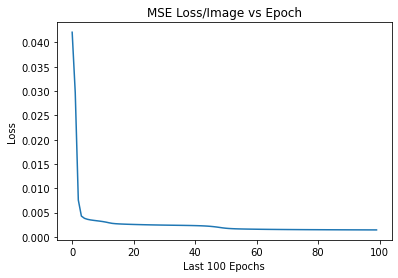

In [10]:
plt.xlabel('Last 100 Epochs')
plt.ylabel('Loss')
plt.title('MSE Loss/Image vs Epoch')

with torch.no_grad():
    # Plotting the last 100 values
    loss_x = []

    for epoch in losses_epoch:
        loss_x.append(sum(epoch)/len(epoch))
    
    plt.plot(loss_x[:])

print(min(loss_x))


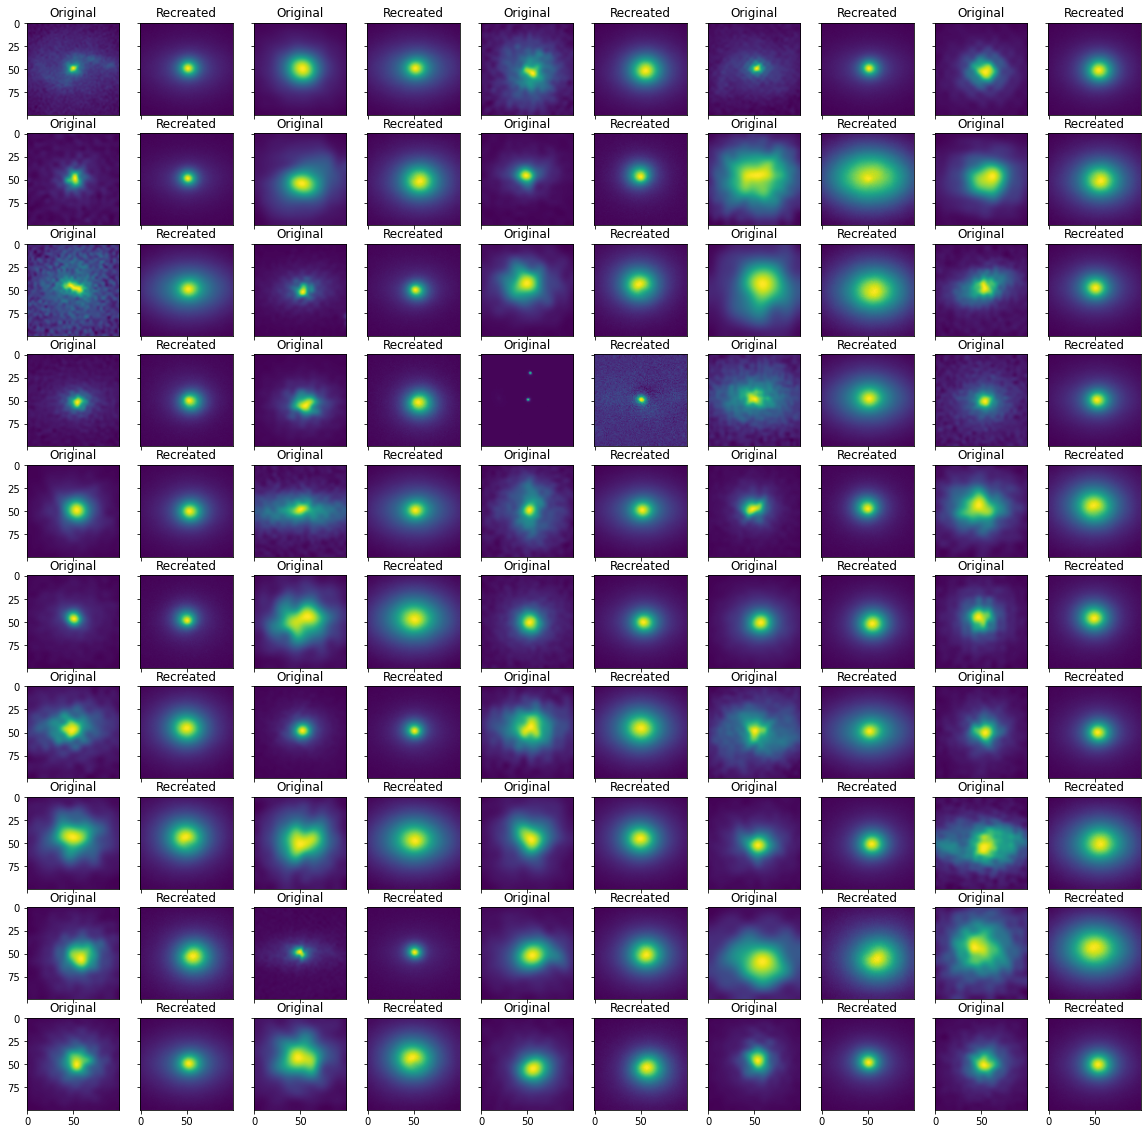

In [11]:
fig, axes = plt.subplots(10, 10, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()
with torch.no_grad():
    i = 0
    for output in outputs:
        item = output[0]
        rec = output[1]

        # Reshape the array for plotting
        item = item.reshape(-1, 100, 100)
        ax[i].imshow(item[0])
        ax[i].set_title('Original')


        rec = rec.reshape(-1, 100, 100)
        ax[i+1].imshow(rec[0])
        ax[i+1].set_title('Recreated')
        
        i += 2
        
        if i == 100:
            break

In [92]:
torch.save(model.state_dict(), 'ae_batch128_bottleneck2.pt')

with open('ae_b128bn2_loss.pickle', 'wb') as f:
    pickle.dump(losses_epoch, f)
    

# Reinitialise model, input model state_dict.


In [20]:
model = AE()
model.load_state_dict(torch.load('ae_batch128_bottleneck2.pt'))

<All keys matched successfully>

# Run first 9 images through CNNAE.

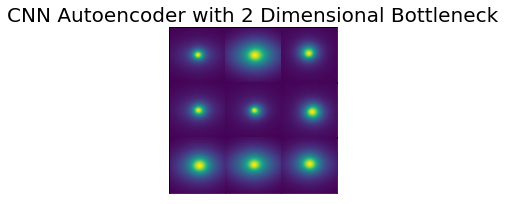

In [21]:
temp_ds = GalacticDataset(X=X[:9])
temp_loader = torch.utils.data.DataLoader(temp_ds, batch_size=1)

temp_outputs = []

for image in temp_loader:
    temp_outputs.append(model(image.reshape(-1, 100*100)))

with torch.no_grad():
    # original 9 galaxies

    fig = plt.figure(figsize=(3, 5), constrained_layout=False)
    outer_grid = fig.add_gridspec(1, 1, wspace=0, hspace=0)

    j = 0

    # gridspec inside gridspec
    inner_grid = outer_grid[0, 0].subgridspec(3, 3, wspace=0, hspace=-0.66)
    axs = inner_grid.subplots()  # Create all subplots for the inner grid.
    for (c, d), ax in np.ndenumerate(axs):
        ax.imshow(temp_outputs[j].reshape((100, 100)))
        ax.set(xticks=[], yticks=[])
        j += 1


    # show only the outside spines

    for i, ax in enumerate(fig.get_axes(), 1):
        ss = ax.get_subplotspec()
        if i == 2:
            ax.set_title('CNN Autoencoder with 2 Dimensional Bottleneck', fontsize=20)
        ax.spines.top.set_visible(ss.is_first_row())
        ax.spines.bottom.set_visible(ss.is_last_row())
        ax.spines.left.set_visible(ss.is_first_col())
        ax.spines.right.set_visible(ss.is_last_col())

    plt.show()


# Encode the images

In [47]:
temp_ds = GalacticDataset(X=X[:])
temp_loader = torch.utils.data.DataLoader(temp_ds, batch_size=1)

encoded_images = []

for image in temp_loader:
    encoded_image = model.encode(image.reshape(-1, 100*100))
    with torch.no_grad():
        encoded_images.append(encoded_image.numpy().reshape(2))
                          

In [49]:
print(encoded_images[0])

[-6.4853177  3.6689582]


# Create galaxy type labelled data

In [28]:
rcsed = Table.read('rcsedzoogz2.fits', format='fits')
data = rcsed.to_pandas()
data['radec'] = data['ra_1'].astype(str) + ',' + data['dec_1'].astype(str)

In [29]:
gz2_classes = []

i = 0

for galaxy in full_data.keys():
    gz2_classes.append(data[data['radec'] == galaxy]['gz2_class'].values[0])
    i += 1
    print(i, end='\r')

In [50]:
galaxies = list(full_data.keys())

cls = []

i = 0
for galaxy in full_data.keys():

    spiral = data[data['radec'] == galaxy]['spiral'].values[0] 
    ellip = data[data['radec'] == galaxy]['elliptical'].values[0] 
    uncertain = data[data['radec'] == galaxy]['uncertain'].values[0] 

    if spiral == 1:
        cls.append('spiral')
    elif ellip == 1:
        cls.append('elliptical')
    elif uncertain == 1:
        cls.append('uncertain')
    i += 1
    print(i, end='\r')

KeyboardInterrupt: 

In [31]:
with open('cls.pickle', 'wb') as f:
    pickle.dump(cls, f)

In [53]:
with open('cls.pickle', 'rb') as f:
    cls = pickle.load(f)

In [82]:
sns_df = pd.DataFrame(data=encoded_images)
sns_df['type'] = cls


# Create r50 labelled data


In [66]:
r50_list = []
i = 0
for galaxy in full_data.keys():
    r50 = data[data['radec'] == galaxy]['petror50_r'].values[0] 
    r50_list.append(r50)
    i+=1
    print(i, end='\r')

In [93]:
with open('r50.pickle', 'wb') as f:
    pickle.dump(r50_list, f)

In [83]:
sns_df['r50'] = r50_list

In [84]:
print(sns_df)

               0         1        type       r50
0      -6.485318  3.668958      spiral  6.758434
1     -13.996429  8.961512      spiral  2.840778
2      -8.235152  1.275095   uncertain  2.089066
3      -6.231909  4.482482   uncertain  3.888339
4      -4.440717  3.877027  elliptical  3.081994
...          ...       ...         ...       ...
12535  -4.461161  4.597798   uncertain  3.231250
12536  -3.588870  2.066394  elliptical  5.162690
12537 -11.658629  8.370444   uncertain  3.745884
12538  -5.977337  4.528703   uncertain  2.069203
12539  -5.923367  3.559930      spiral  3.737998

[12540 rows x 4 columns]


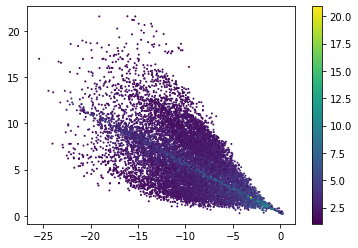

In [91]:
# seaborn pairplot

headers = []

for i, header in enumerate(sns_df.columns[:-2], 1):
    headers.append(f'Feat. {i}')

headers.append('type')
headers.append('r50')
sns_df.columns = headers

plt.scatter(x=sns_df['Feat. 1'], y=sns_df['Feat. 2'], c=sns_df['r50'], s=1)
cbar = plt.colorbar()


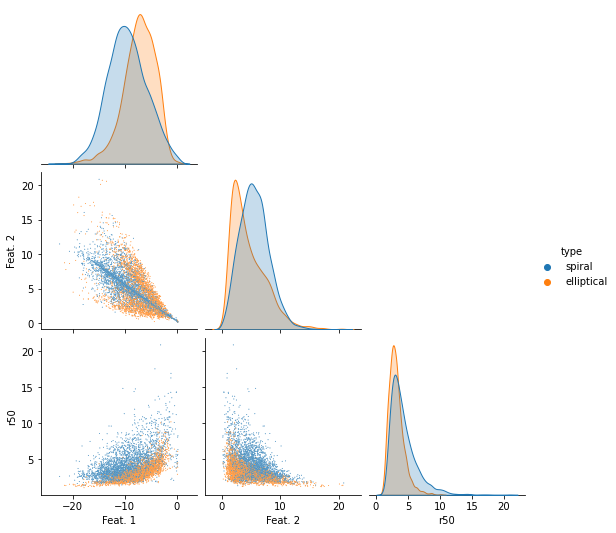

In [89]:
# seaborn pairplot


# headers = []

# for i, header in enumerate(sns_df.columns[:-1], 1):
#     headers.append(f'Feat. {i}')

# headers.append('type')
# sns_df.columns = headers

pp = sns.pairplot(data=sns_df[sns_df['type']!='uncertain'], hue='type', corner=True, plot_kws={"s": 1})
# pp = sns.pairplot(data=sns_df, hue='type', corner=True)


# Preparing dataset for pairwise plot with physical/morphological colormapping

In [ ]:
# initialise dataframe with galaxy information

rcsed = Table.read('rcsedzoogz2.fits', format='fits')
data = rcsed.to_pandas()
data['radec'] = data['ra_1'].astype(str) + ',' + data['dec_1'].astype(str)

cob = pca.components_

i = 0

for j in range(pca.components_.shape[0]):
    data[f'eval_{j}'] = None

for galaxy, model in full_data.items():
    img = model
    scale_factor = 1/(img.max()-img.min())
    img_scaled = (img-img.min())*scale_factor
    img_scaled  = img_scaled - img_scaled.mean() # center data
    
    eva = pca.transform(img_scaled.reshape([1, 10000]))
    eva_list = list(eva.flatten())

    index = data.loc[(data['radec'] == galaxy)].index
    
    for j in range(len(eva_list)):
        data.at[index[0], f'eval_{j}'] = eva_list[j]
    
    print(i, end='\r')
    i += 1

final_dataset = data[data['eval_0'].isna() == False]
    

In [55]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

/tmp/ipykernel_3428320/1143697772.py:10: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  fig.colorbar(img)


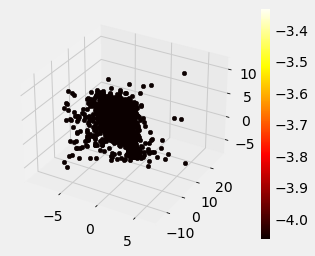

In [157]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def plot_latent(autoencoder, data, num_batches=10000):
    for i, image in enumerate(data):
        z = autoencoder.encoder(image[0].reshape(-1, 100*100))
        z = z.to('cpu').detach().numpy()
        img = ax.scatter(z[:, 0], z[:, 1], z[:, 2], c=z[:, 3], cmap=plt.hot())
        if i > num_batches:
            fig.colorbar(img)
            break
            
data = torch.utils.data.DataLoader(dataset = full_tensor_dataset,
                                          batch_size=1,
                                          shuffle=True)

plot_latent(model, data)

In [162]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 100
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        print(y)
        for j, x in enumerate(np.linspace(*r0, n)):
            print(x)
            z = torch.Tensor([[x, y]])
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(100, 100).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

plot_reconstructed(model, data, )

-10.0


TypeError: _linspace_dispatcher() takes from 2 to 7 positional arguments but 24277 were given